# MAC0219 - Programação Concorrente e Paralela

## EP1: Cálculo do Conjunto de Mandelbrot em Paralelo com Pthreads e OpenMP

Gabriel Brandão de Almeida, NUSP. 10737182.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st

sns.set_theme()

In [2]:
files = {
    'seq': 'results/mandelbrot_seq.csv',
    'pth': 'results/mandelbrot_pth.csv',
    'omp': 'results/mandelbrot_omp.csv',
    'ompi': 'results/mandelbrot_ompi.csv',
    'ompi_pth': 'results/mandelbrot_ompi_pth.csv'
}

In [18]:
def read_stats(path):
    return pd.read_csv(path)

In [22]:
stats = dict()

for prog, path in files.items():
    stats[prog] = read_stats(path)

In [42]:
def plot_stats(df, x, y, title, xlabel, ylabel, hue = None, legend = None, legend_title = None):
    fig, ax1 = plt.subplots(figsize=(10,8))
    
    for col in y:
        sp1 = sns.lineplot(data=df, x=x, y=col, hue=hue, ax=ax1, palette='deep', style=hue, markers=True)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    ax_legend = ax1.get_legend()
    if legend and ax_legend:
        handles = legend.legendHandles
        legend.remove()
        ax1.legend(
            handles,
            legend,
            title=legend_title
        )

#     plt.savefig(f"{title}.png".replace('/',''), format='png', dpi=150)

In [ ]:
def plot_size_grid_stats(df, x, y, title, xlabel, ylabel):
    fig, axs = plt.subplots(4, 3, figsize=(25, 25))
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')

    for size in range(4, 14):
        df = df[df['size'] == 2**size]

        i, j = (size-4)//3, (size-4)%3

        sp1 = sns.lineplot(data=df, x=x, y=y, hue='region', ax=axs[i, j], palette='deep', style='region', markers=True)
        axs[i,j].set_title(title.format(size=2**size))
        axs[i,j].set_xlabel(xlabel)
        axs[i,j].set_ylabel(ylabel)
        legend = axs[i,j].get_legend()
        handles = legend.legendHandles
        legend.remove()
        axs[i,j].legend(
            handles,
            ['Full Picture', 'Seahorse Valley', 'Elephant Valley', 'Triple Spiral Valley'],
            title='Região'
        )
        
#     plt.savefig(f"{title}.png".replace('/',''), format='png', dpi=150)

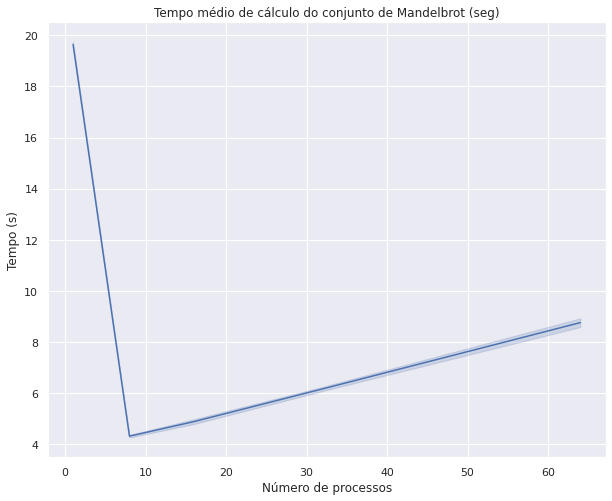

In [33]:
plot_stats(stats['ompi'], 'procs', ['computation_time'], 'Tempo médio de cálculo do conjunto de Mandelbrot (seg)', 'Número de processos', 'Tempo (s)')

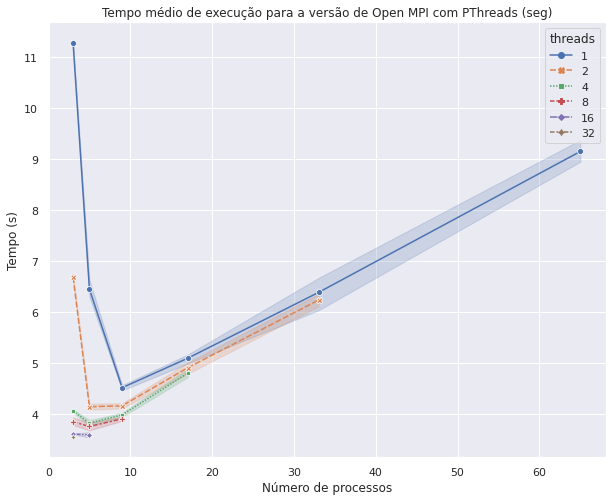

In [43]:
plot_stats(stats['ompi_pth'], 'procs', ['computation_time'], 'Tempo médio de execução para a versão de Open MPI com PThreads (seg)', 'Número de processos', 'Tempo (s)', 'threads')

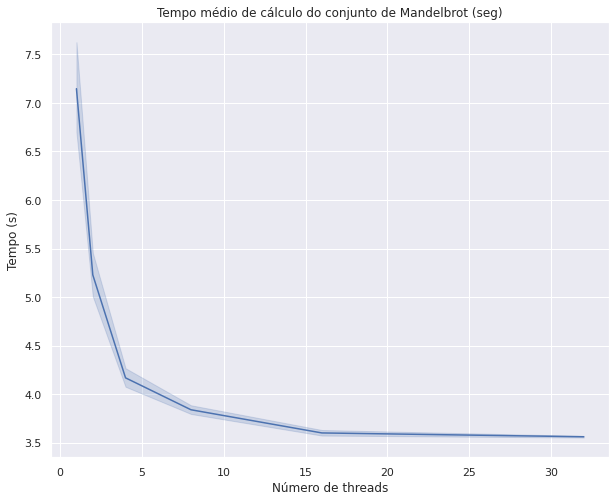

In [26]:
plot_stats(stats['ompi_pth'], 'threads', ['computation_time'], 'Tempo médio de execução para a versão de Open MPI (seg)', 'Número de threads', 'Tempo (s)', None)

## Experimentos

Para cada uma das versões, foram realizadas medições de tempo de 10 execuções do programa. Os gráficos apresentados a seguir, mostram a média das medições e seus intervalos de confiança (95%).

## Resultados - Sequencial

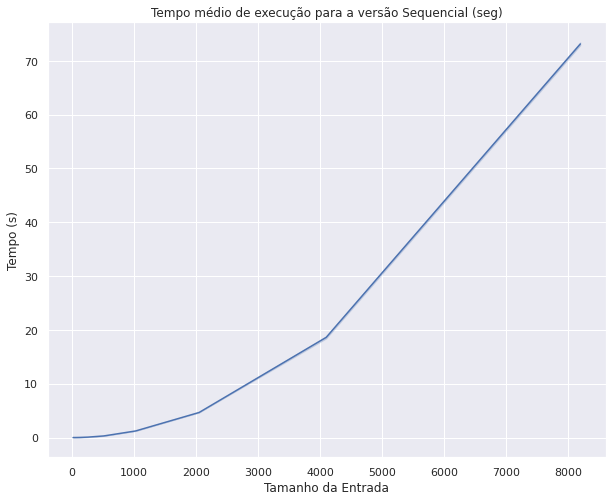

In [35]:
data = stats['seq']

plot_stats(data[data['region'] == 4], 'size', ['computation_time'], 'Tempo médio de execução para a versão Sequencial (seg)', 'Tamanho da Entrada', 'Tempo (s)')

Observa-se que o tempo de execução tem crescimento similar a uma função quadrática no tamanho da entrada, como era esperado, uma vez que a entrada é uma matrix quadrada.

Note que quanto maior o tamanho da entrada, menor o impacto das operações de I/O e alocação de memória no tempo de execução. Para tamanhos de entrada pequenos (< 512), o tempo decorrido em cada etapa (I/O, alocação e liberação de memória, e cálculos) é muito similar, contudo, quando o tamanho de entrada aumenta, o tempo médio gasto nas operações que não incluem o cálculo do conjunto de Mandelbrot, somam, no máximo, 3 segundos, enquanto o tempo médio de execução corresponde a, no máximo, 75 segundos.

Além disso, observa-se que as regiões impactam fortemente o tempo de execução do programa. Isso ocorre pois regiões mais complexas, isto é, com mais áreas contendo pontos em que a convergência demanda mais iterações. Sendo assim, pode-se concluir que a figura completa é mais simples e as demais figuras são similarmente complexas.

## Resultados - PThreads

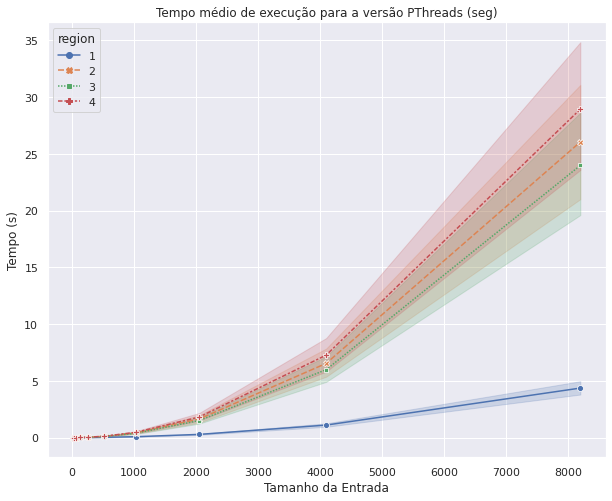

In [45]:
plot_stats(stats['pth'], 'size', ['computation_time'], 'Tempo médio de execução para a versão PThreads (seg)', 'Tamanho da Entrada', 'Tempo (s)', 'region')

Nota-se que o tempo de execução tem maior variabilidade do que a versão sequencial do programa. A causa dessa dispersão da média dos tempos provalmente está relacionada ao fato da execução paralela das tarefas concorrer com os demais processos do computador.

Similarmente ao programa sequencial, as regiões mais complexas, requerem maior tempo de execução para calcular a figura.

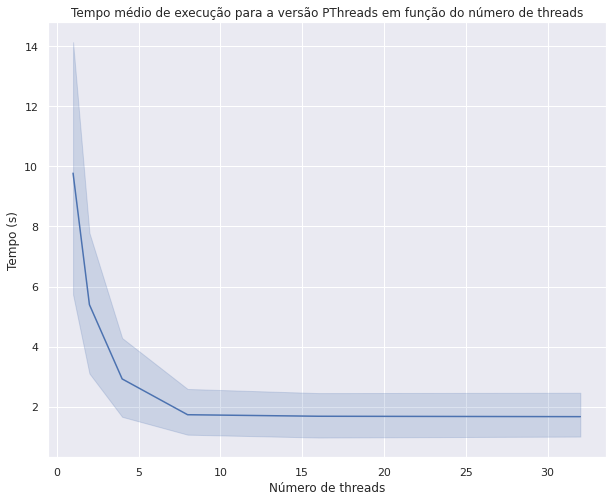

In [41]:
data = stats['pth']

plot_stats(data[data['region'] == 4], 'threads', ['computation_time'], 'Tempo médio de execução para a versão PThreads em função do número de threads', 'Número de threads', 'Tempo (s)')

Agora observando o gráfico acima, em geral, nota-se que o tempo médio de execução diminui com o aumento do número de threads. Quando o número de threads duplica, o tempo médio de execução diminui pela metade antes do número de threads exceder 8. Depois disso, o tempo tem comportamento constante, indicando que não há ganho ao aumentar o número de threads para o processador da máquina de teste (possui 4 núcleos), pois nem todas as tarefas estão sendo executadas paralelamente.

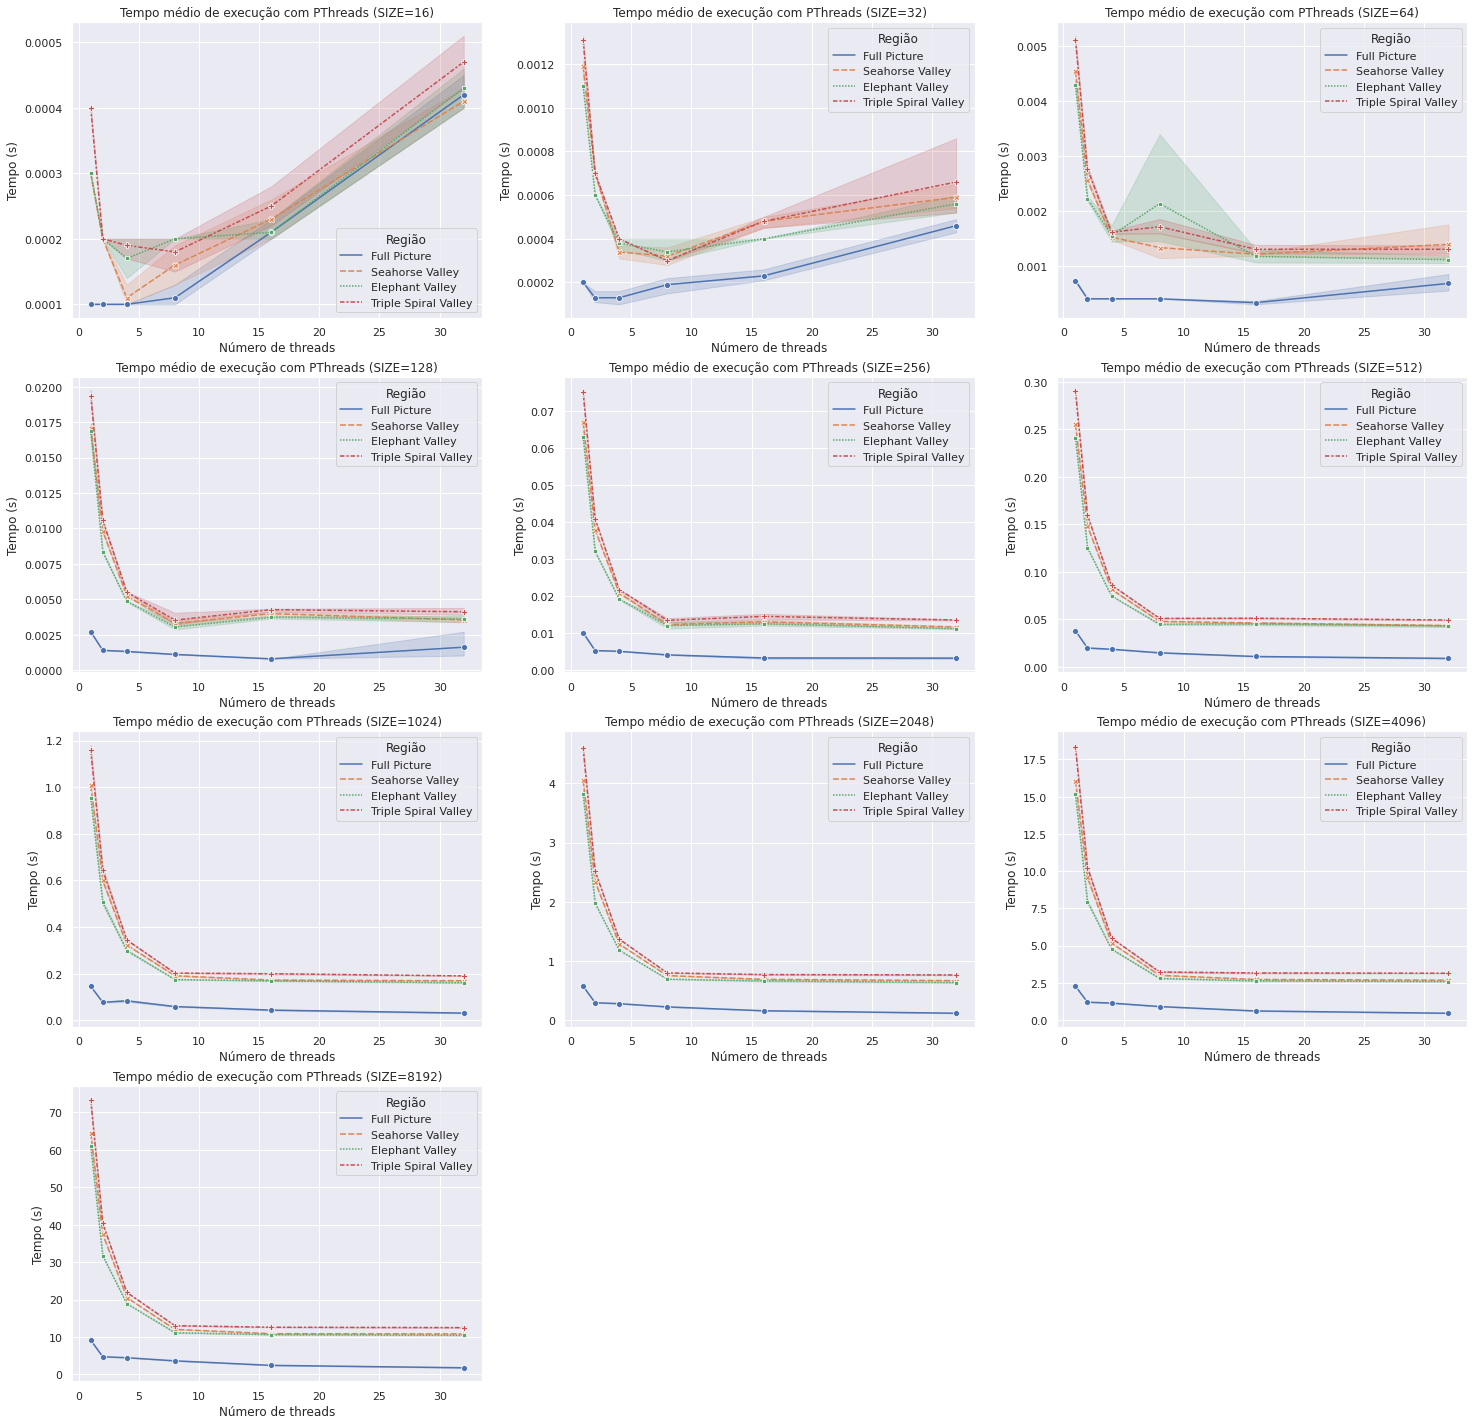

In [76]:
fig, axs = plt.subplots(4, 3, figsize=(25, 25))
axs[3, 1].axis('off')
axs[3, 2].axis('off')

for size in range(4, 14):
    df = stats['pth'][stats['pth']['size'] == 2**size]
    
    i, j = (size-4)//3, (size-4)%3
    
    sp1 = sns.lineplot(data=df, x='threads', y='computation_time', hue='region', ax=axs[i, j], palette='deep', style='region', markers=True)
    axs[i,j].set_title(f'Tempo médio de execução com PThreads (SIZE={2**size})')
    axs[i,j].set_xlabel('Número de threads')
    axs[i,j].set_ylabel('Tempo (s)')
    legend = axs[i,j].get_legend()
    handles = legend.legendHandles
    legend.remove()
    axs[i,j].legend(
        handles,
        ['Full Picture', 'Seahorse Valley', 'Elephant Valley', 'Triple Spiral Valley'],
        title='Região'
    )

Quando o tamanho da entrada é menor que 64, o comportamento de tempo difere dos demais, pois o overhead de criação de threads consome mais tempo do que a computação da figura.